# 1 Executive Summary

This notebook is ...

# 2 Introduction

This main audience of this analysis is for young adults and college students who are looking to get a job within the Philippine Government available as job posts in the Civil Service Commission (CSC) of the Philippines.

- Use regression and classification for ...

# 3 Problem Statement

As data science students, we aim to explore whether the Philippine government is actively seeking professionals with skills in data science and related fields. This study seeks to determine the extent to which data science roles appear in government job postings, whether the listed qualifications align with our current competencies, and if the offered salaries are competitive enough to attract individuals pursuing a career in this domain.

# 4 Dataset Description

The dataset contains records of job listings posted between early 2024 and the present. These listings are published by the Civil Service Commission (CSC) of the Philippines and represent government jobs with corresponding government salaries.

The data is sourced from the CSC's official job postings page: https://csc.gov.ph/career/. It is presented in a paginated tabular format on the website. However, there is no direct method for downloading the data, so techniques such as web scraping are required to retrieve it.

The final features sourced from the scraping process consists of 14 features. Most of them are text in nature. The following is the data schema.
| Column Name        | Data Type   | Description           |
|--------------------|-------------|------------------------|
| jobId              | INT         | Unique identifier for every job post. ex. 42333014        |
| Agency             | VARCHAR     | The agency that published this job post. ex. DEPARTMENT OF EDUCATION                    |
| Region             | VARCHAR     | The location of the job. ex. REGION X           |
| PlaceOfAssignment  | VARCHAR     | The location of the job. ex. CSC NCR            |
| PositionTitle      | VARCHAR     | ex. Teacher 1          |
| PlantillaNo        | VARCHAR     | ex. 2025-047           |
| SalaryGrade        | VARCHAR     | Salary Categories. Higher the grade, higher the salary. ex. 24                 |
| MonthlySalary      | INT         | Monthly Salary of the job in Philippine Peso (PHP). ex. 34000              |
| Eligibility        | VARCHAR     | ex. Career Service Professional (Second Level Eligibility)   |
| Education          | VARCHAR     | ex. Bachelors Degree   |
| Training           | VARCHAR     | Time of on the job training ex. 16hours of relevant Training |
| Experience         | VARCHAR     | Previous working experience ex. Three(3) years relevant experience |
| Competency         | VARCHAR     | Description of competencies needed.   |
| Posting Date       | DATE        | Date of the job post when it was published. |
| Closing Date       | DATE        | Date of the job post when it expires. |


# 5 Methodology

2025-05-03 18:54:58.946 | INFO     | ml_final_project.config:<module>:11 - PROJ_ROOT path is: D:\Documents\3 Production Save Files\1 Cloned repositories\ml-final-project


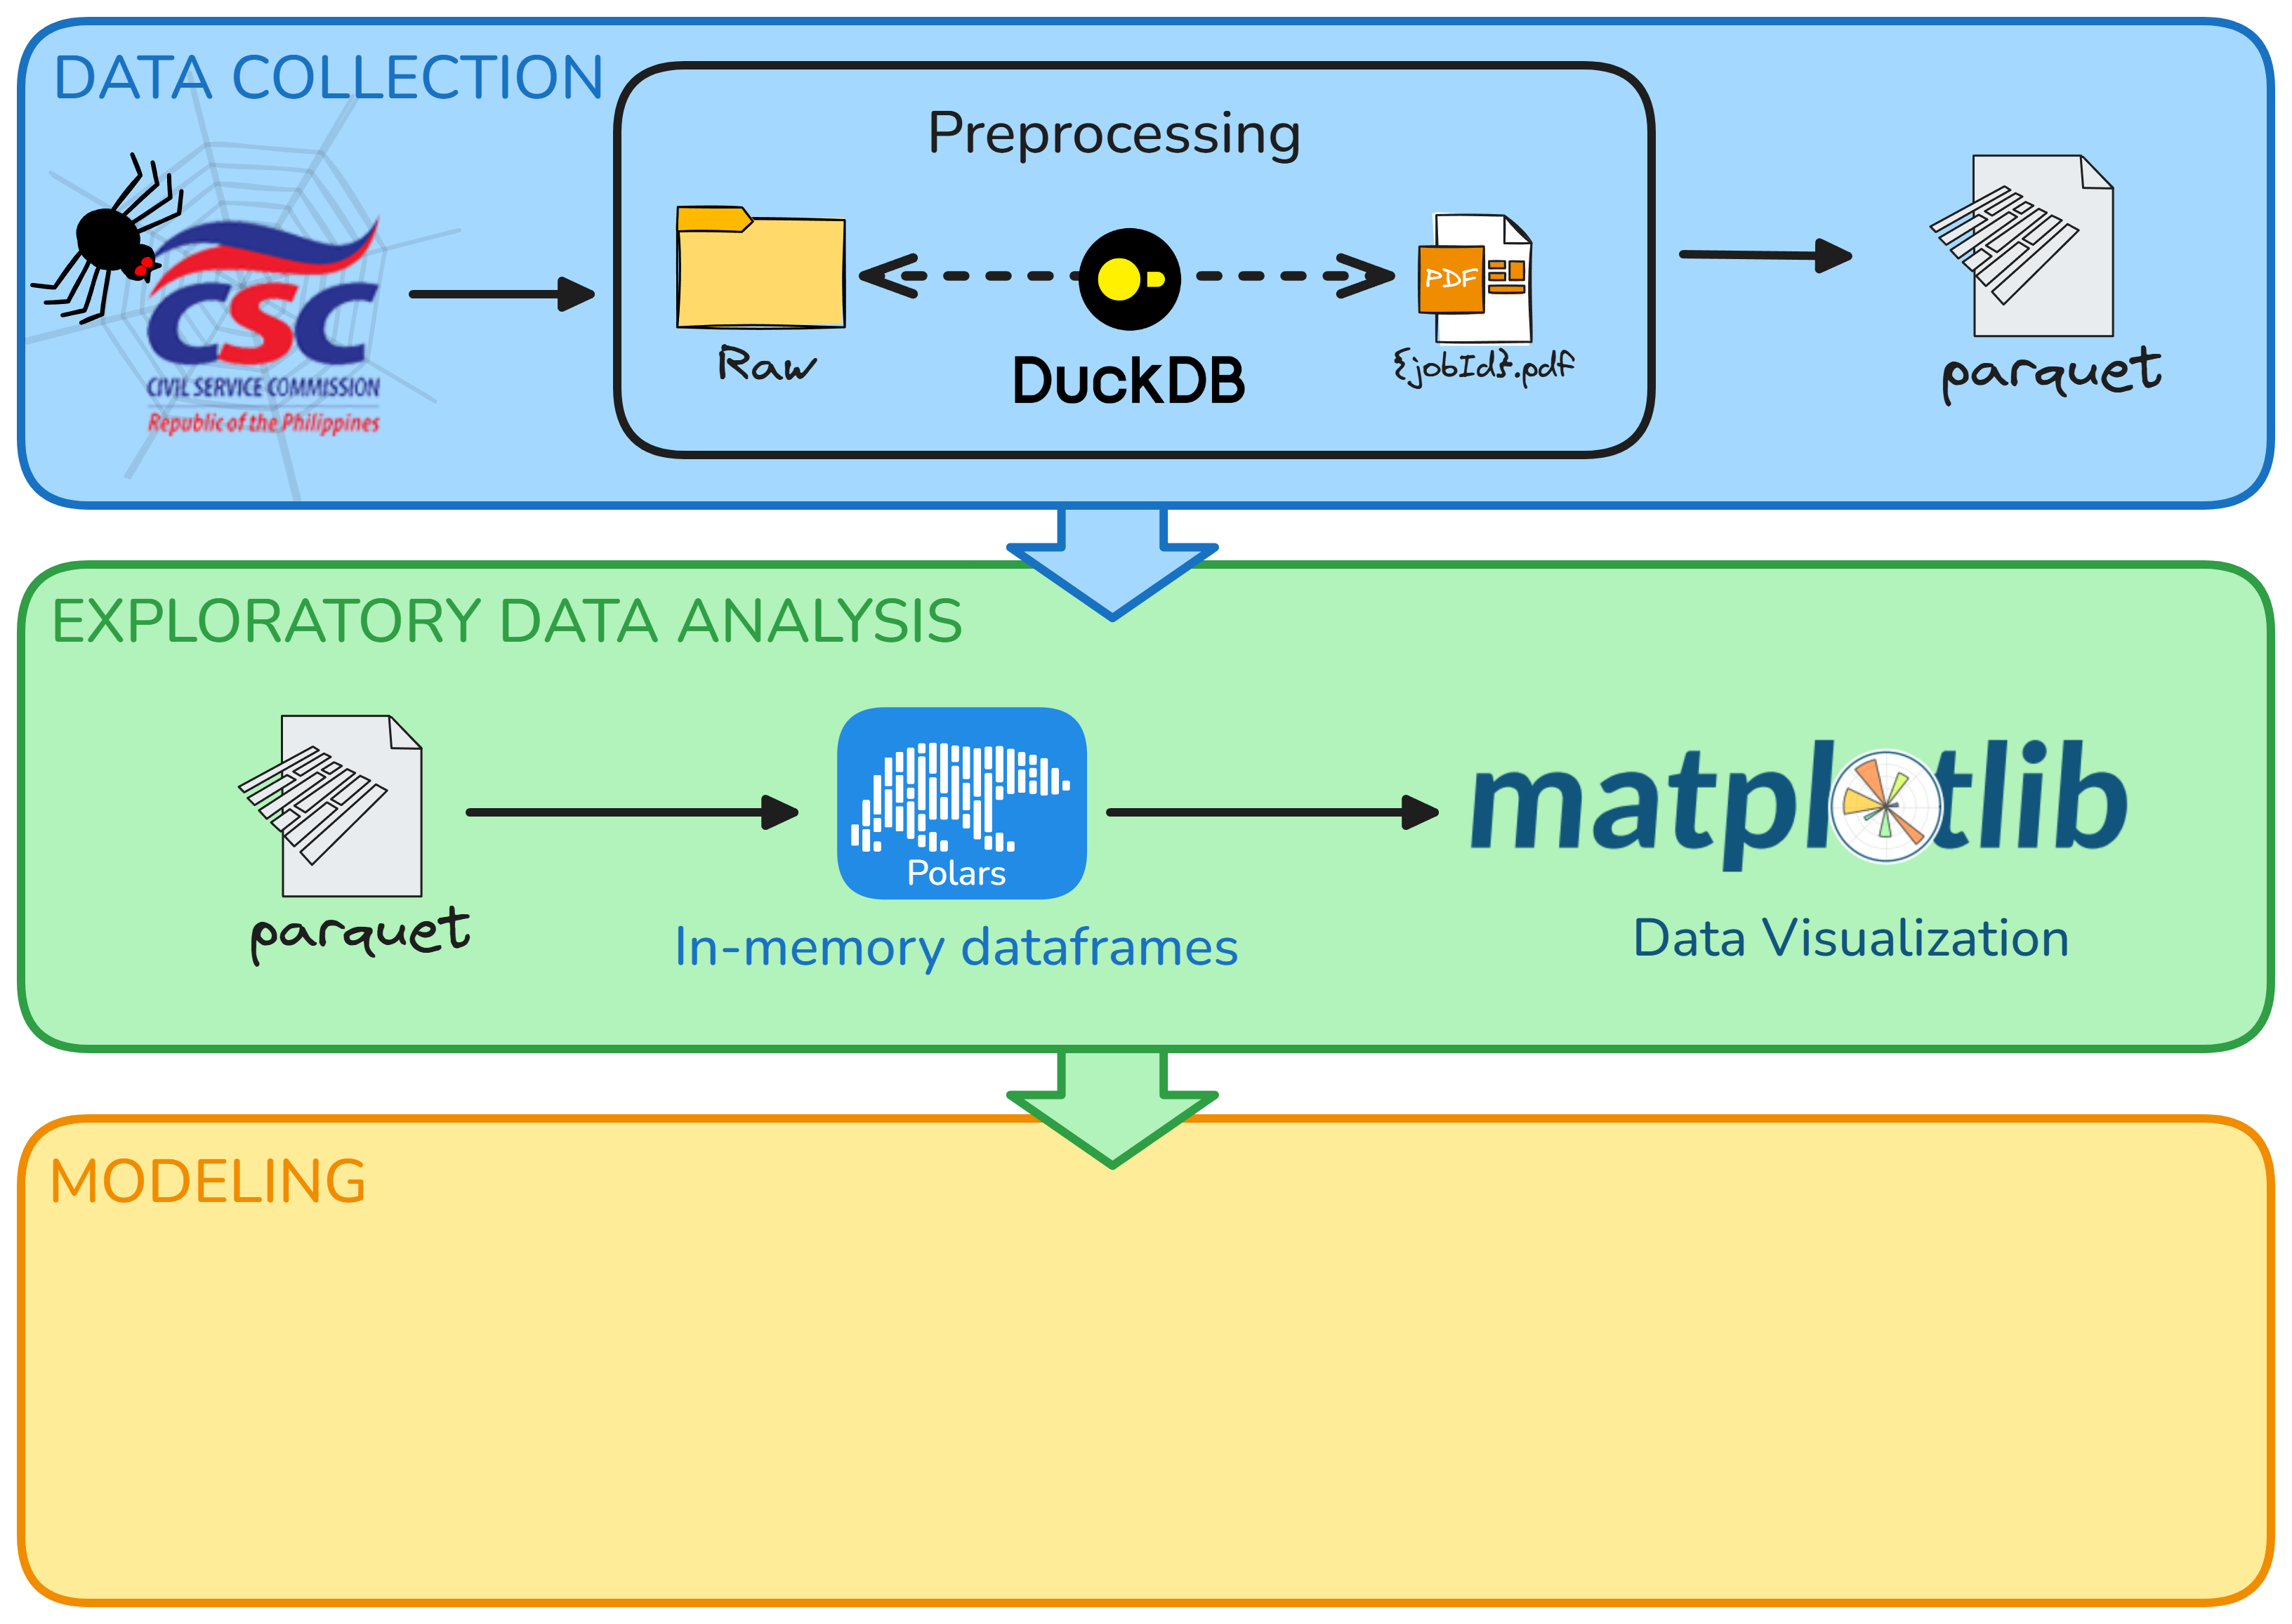

In [1]:
from IPython.display import Image, display
from ml_final_project.config import FIGURES_DIR
display(Image(FIGURES_DIR / "ml_final_exam_methodology.png"))

## 5.1 Notebook Setup

Importing required libraries

In [2]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from ml_final_project.config import MPL_STYLE_DIR, PROCESSED_DATA_DIR

# Use custom style for plots
plt.style.use(MPL_STYLE_DIR / "iragca_ml.mplstyle")

Loading our data

In [3]:
dataPath = PROCESSED_DATA_DIR / "CivilServiceCommission" / "civilservicecommission.parquet"
df = pl.read_parquet(dataPath)
df

jobId,Agency,Region,PlaceOfAssignment,Posting Date,Closing Date,Position Title,SalaryGrade,MonthlySalary,Eligibility,Education,Training,Experience,Competency,Plantilla Item No.
i32,str,str,str,date,date,str,str,i32,str,str,str,str,str,str
4235342,"""BICOL MEDICAL CENTER""","""Region V""","""Division Office, Division of A…",2024-12-06,2024-12-16,"""NURSE III""","""14""",33843,"""PBET/LET/RA1080 Teacher""","""Bachelor's degree in""","""None Required""","""None Required""","""N/A""","""OSEC-DOHB-NURS3-390074-2015"""
4267059,"""COTABATO REGIONAL AND MEDICAL …","""Region XII""","""PETDU-CRMC Cotabato City""",2025-01-08,2025-01-18,"""Training Specialist II""","""15""",38413,"""Career Service Professional/Se…","""Bachelor'S Degree""","""Specialist II""","""1 Year Of Relevant""","""""","""OSEC-DOHB-TRNSP2-840012-2024"""
4325512,"""DEPARTMENT OF EDUCATION""","""Region XII""","""ELEMENTARY- SDO SULTAN KUDARAT""",2025-02-07,2025-02-17,"""Head Teacher IV""","""17""",47247,"""RA 1080, as amended (Teacher)""","""Bachelor's degree in Elementar…","""24 hours of relevant training""","""HT for 3 years; or MT for 2 ye…","""""","""OSEC-DECSB-HTEACH4-840037-2021"""
4347023,"""MANILA, NCR""","""NCR""","""ELEMENTARY SCHOOLS""",2025-02-19,2025-03-03,"""TEACHER III""","""13""",34421,"""RA 1080 (TEACHER)""","""BEED or Bachelor's Degree plus…","""None Required""","""2 years of relevant experience""","""Not Applicable""","""OSEC-DECSB-TCH3-33077-1998"""
4318456,"""DEPARTMENT OF EDUCATION""","""Region XI""","""Sta. Cruz National High School""",2025-02-04,2025-02-14,"""MASTER TEACHER I (Secondary Gr…","""18""",51304,"""PBET/Teacher/RA 1080""","""Bachelor of Secondary""","""None Required""","""3 Years Relevant""","""N/A""","""OSEC-DECSB-MTCHR1-750206-2021"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4247090,"""DEPARTMENT OF EDUCATION""","""Region IV""","""Schools Division of Lipa City …",2024-12-17,2024-12-27,"""Teacher II""","""12""",30705,"""RA 1080, Teacher""","""Bachelor of Secondary""","""None Required""","""1 year of relevant experience""","""N/A""","""OSEC-DECSB-TCH2-240048-2001"""
4319185,"""BUREAU OF CORRECTIONS""","""NCR""","""Bureau of Corrections""",2025-01-14,2025-01-24,"""Corrections Officer I""","""11""",29668,"""RA 1080/ CS Professional/ CSC …","""Bachelor's Degree""","""None required""","""None required""","""N/A""","""BCORB-CO1-890-2024"""
4365994,"""DEPARTMENT OF EDUCATION""","""Region V""","""Elementary""",2025-02-24,2025-03-07,"""Teacher III""","""13""",34421,"""RA 1080 (Teacher)""","""Bachelor of Elementary""","""None Required""","""2 years relevant experience""","""N/A""","""OSEC-DECSB-TCH3-391749-2020"""


In [14]:
df["SalaryGrade"].value_counts().sort("count", descending=True).head(10)

SalaryGrade,count
str,u32
"""11""",19276
"""12""",11998
"""13""",10995
"""15""",5549
"""8""",5335
"""10""",4825
"""18""",4580
"""4""",4567
"""16""",4499


## 5.1 Data Collection

To collect our data, we web scrape it from the CSC job post board. We utilized Microsoft's [Playwright](https://github.com/microsoft/playwright) framework for web testing and automation.

## 5.2 Exploratory Data Analysis

asdf

### 5.2.1 Heatmap Frequency of Available Data

Preprocessing the needed data structure for the heatmap (a pivot table)

In [55]:
def insert_missing_months(df):
    for month in range(1, 13):
        if month in df["month"].to_list():
            continue
        new_row = pl.DataFrame(
            {
                "month": month,
                "2000": None,
                "2014": None,
                "2018": None,
                "2019": None,
                "2023": None,
                "2024": None,
                "2025": None,
            },
            schema=df.schema,
        )
        df = df.vstack(new_row)

    return df


pivot_table = insert_missing_months(
    #  Group by every month and count the number of instances
    df.sort("Posting Date")
    .group_by_dynamic(
        "Posting Date",
        every="1m",
    )
    .agg(pl.col("MonthlySalary").count().alias("count"))
    #  Create new columns with the month and year of the Posting Date
    #  and group by year and month
    .with_columns(
        [
            pl.col("Posting Date").dt.month().alias("month"),
            pl.col("Posting Date").dt.year().alias("year"),
        ]
    )
    .group_by(["year", "month"])
    .agg(pl.col("count").sum())
    #  Create a pivot table of the counts
    .pivot(
        on="year",
        index="month",
        values="count",
        aggregate_function="sum",
        sort_columns=True,
    )
).sort("month")

Plotting the heatmap

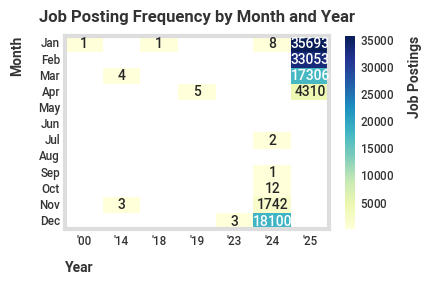

In [56]:
fig, ax = plt.subplots()

MONTHS = [
    "Jan", "Feb", "Mar", "Apr",
    "May", "Jun", "Jul", "Aug",
    "Sep", "Oct", "Nov", "Dec",
]

YEARS = [
    "'00", "'14", "'18", "'19",
    "'23", "'24", "'25",
]

sns.heatmap(
    data=pivot_table.drop("month"),
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    cbar_kws={"label": "Job Postings"},
    xticklabels=YEARS,
    yticklabels=MONTHS,
)
plt.title("Job Posting Frequency by Month and Year")
plt.xlabel("Year")
plt.ylabel("Month")

ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["top"].set_visible(True)

## 5.3 Data Preparation

## 5.4 Modeling

# 6 Results and Discussion

# 7 Conclusion






## 7.1 Recommendation


### 7.1.1 Preprocessing

Scalable PDF preprocessing
- MapReduce
- Parallel processing



# Appendix

## Appendix 1: Scraping